# Analysis of Immigration Data in the United States

### Project Summary

In this project, we will be looking at the immigration data for the united states. 
By the end of this Exploratory Data Analysis (EDA) we'd be able to have some insights on following questions:

* How temperature affects the volume of travellers ? 
* Which season of travel is most preferred ? 
* What sort of relationship is between the volume of travel and the number of entry ports (i.e. airports) ?
* How the volume of travel and the demographics of various cities are dependent on each other ?

#### Resources used :

* **I94 Immigration Data**
The I-94 provides a count of visitor arrivals to the United States (with stays of 1-night or more and visiting under 
certain visa types) to calculate U.S. travel and tourism volume exports
    
   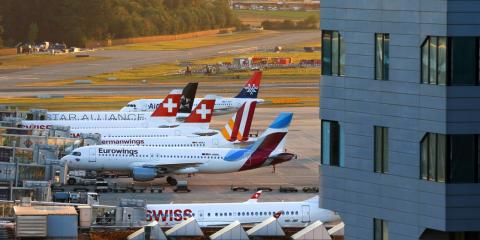
    
    
    We've following files in the directory of this project:

   * _countries.csv_ : table containing country codes used in the dataset, extracted from the data dictionary
   * _i94portCodes.csv_: table containing city codes used in the dataset, extracted from the data dictionary



* **World Temperature Data**: This dataset comes from Kaggle and includes the temperatures of various cities in the world from 1743 to 2013.

* **U.S. City Demographic Data**: This data comes from OpenSoft. It contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000 and comes from the US Census Bureau's 2015 American Community Survey.

* **Airport Code Table**: This is a simple table of airport codes and corresponding cities.


The project follows the follow steps:
* **Step 1**: Scope the Project and Gather Data
    * Since the scope of the project will be highly dependent on the data, these two things happen simultaneously. In this step, we’ll:
           
         * Identify and gather the data we'll be using for your project 
           (at least two sources and more than 1 million rows).
         * Explain what end use cases we'd like to prepare the data for.

* **Step 2**: Explore and Assess the Data
    * Explore the data to identify data quality issues, like missing values, duplicate data, etc.
    * Document steps necessary to clean the data

* **Step 3**: Define the Data Model
    * Map out the conceptual data model and explain why we'd chose that model
    * List the steps necessary to pipeline the data into the chosen data model

* **Step 4**: Run ETL to Model the Data
    * Create the data pipelines and the data model
    * Include a data dictionary
    * Run data quality checks to ensure the pipeline ran as expected
        * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
        * Unit tests for the scripts to ensure they are doing the right thing
        * Source/count checks to ensure completeness
* **Step 5**: Complete Project Write Up
    Answer these questions:
    * What's the goal? What queries would we want to run? How would Spark or Airflow be incorporated? Why did we choose the model we chose?
    * Clearly state the rationale for the choice of tools and technologies for the project.
    * Document the steps of the process.
    * Propose how often the data should be updated and why.
    * Post your write-up and final data model in a GitHub repo.
    * Include a description of how you would approach the problem differently under the following scenarios:
        * If the data was increased by 100x.
        * If the pipelines were run on a daily basis by 7am.
        * If the database needed to be accessed by 100+ people.

In [1]:
# Importing necessary lib
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, date_add
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd

### Step 1: Scope the Project and Gather Data

#### Scope 
##### Datasets:
    The following datasets are used for the scope of this project:
    
- [x] I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. [This](https://www.trade.gov/national-travel-and-tourism-office) is where the data comes from. There's a sample file so we can take a look at the data in csv format before reading it all in. We do not have to use the entire dataset, just use what we need to accomplish the goal you set at the beginning of the project.
- [x] World Temperature Data: This dataset came from Kaggle. You can read more about it [here](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data).
- [x] U.S. City Demographic Data: This data comes from OpenSoft. You can read more about it [here](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).
- [x] Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data).


#### Accessing the datasets

* Immigration Data
    We can access the immigration data in a folder with the following path: <code>../../data/18-83510-I94-Data-2016/</code> 
    There's a file for each month of the year. An example file name is <code>i94_apr16_sub.sas7bdat.</code> Each file has a three-letter abbreviation for the month name. So a full file path for June would look like this: <code>../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat.</code> Below is what it would look like to import this file into pandas. Note: these files are large, so we'll have to think about how to process and aggregate them efficiently
    
    <code>fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'df = pd.read_sas(fname, 'sas7bdat', encoding="ISO-8859-1")</code>
    
    
* The most important decision for modeling with this data is thinking about the level of aggregation. Do you want to aggregate by airport by month? Or by city by year? This level of aggregation will influence how you join the data with other datasets. There isn't a right answer, it all depends on what you want your final dataset to look like.


* Temperature Data

    We can access the temperature data in a folder with the following path: <code>../../data2/.</code> There's just one file in that folder, called <code>GlobalLandTemperaturesByCity.csv.</code> Below is how you would read the file into a pandas dataframe.

    <code>fname = '../../data2/GlobalLandTemperaturesByCity.csv'
    df = pd.read_csv(fname)</code>

## Immigration Dataset
The immigration dataset is large, containing approximately 3m lines.

We will use a subset of approx 1000 rows in a csv to explore it

In [2]:
# Read in the data here
df_immig_sample = pd.read_csv('immigration_data_sample.csv')
pd.set_option('display.max_columns', 50)
df_immig_sample.head(10)

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT
5,721257,1481650.0,2016.0,4.0,577.0,577.0,ATL,20552.0,1.0,GA,20606.0,51.0,2.0,1.0,20160408,NaN,NaN,T,N,NaN,M,1965.0,10072016,M,NaN,DL,7.368526e+08,910,B2
6,1072780,2197173.0,2016.0,4.0,245.0,245.0,SFR,20556.0,1.0,CA,20635.0,48.0,2.0,1.0,20160412,NaN,NaN,T,O,NaN,M,1968.0,10112016,F,NaN,CX,7.863122e+08,870,B2
7,112205,232708.0,2016.0,4.0,113.0,135.0,NYC,20546.0,1.0,NY,20554.0,33.0,2.0,1.0,20160402,NaN,NaN,G,O,NaN,M,1983.0,06302016,F,NaN,BA,5.547449e+10,00117,WT
8,2577162,5227851.0,2016.0,4.0,131.0,131.0,CHI,20572.0,1.0,IL,20575.0,39.0,2.0,1.0,20160428,NaN,NaN,O,O,NaN,M,1977.0,07262016,NaN,NaN,LX,5.941342e+10,00008,WT
9,10930,13213.0,2016.0,4.0,116.0,116.0,LOS,20545.0,1.0,CA,20553.0,35.0,2.0,1.0,20160401,NaN,NaN,O,O,NaN,M,1981.0,06292016,NaN,NaN,AA,5.544979e+10,00109,WT


The definition of the fields is included in the file <code>I94_SAS_Labels_Descriptions.SAS</code>

We'll primarily be working with the following fields:

- [x] i94cit : country of citizenship
- [x] i94res : country of residence
- [x] i94port: arrival airport
- [x] arrdate: arrival date. 
- [x] i94mode
- [x] i94addr
- [x] depdate
- [x] i94bir
- [x] i94visa
- [x] occup
- [x] biryear
- [x] dtaddto
- [x] gender
- [x] insnum
- [x] airline
- [x] admnum
- [x] fltno
- [x] visatype




#### Adding data dictionaries
In the next step, we will add details from the data dictionnary.

These will replace the codes in our data model since we work with denormalized data models.

Adding dictionary for columns I94CIT & I94RES (countries.csv) which we assume corresponds to country of citizenship and country of residence of the travelers.

In [3]:
# Reading and vizualising CountryCodes

df_countryCodes = pd.read_csv('countries.csv')
df_countryCodes.head()

,code,country
0,582,MEXICO
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [4]:
#adding a correspondance table between i94port codes and city that was the port of entry (i94portCodes.csv)
#vizualising top 5 rows

i94portCodes = pd.read_csv('i94portCodes.csv')
i94portCodes.head()

,code,location,state
0,ALC,ALCAN,AK
1,ANC,ANCHORAGE,AK
2,BAR,BAKER AAF - BAKER ISLAND,AK
3,DAC,DALTONS CACHE,AK
4,PIZ,DEW STATION PT LAY DEW,AK


#### World Temperature data


In [5]:
#Reading temperature from file:

fname = '../../data2/GlobalLandTemperaturesByCity.csv'
df_temperature = pd.read_csv(fname)

df_temperature.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


#### Demographic Data
Demographic data
Our dataset contains details on the reason for traveling. 
We want to see if there is a connection between the flow of immigration and the demographic data of various US cities.

In [6]:
# Read in the data here
df_demographics = pd.read_csv('us-cities-demographics.csv', sep=';')

# See the first few rows
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


#### Airport data

Since airports are the point of entry for these immigrants, 
we will include airport information in our data.

This data will allow us to connect airport data to the airport codes

In [7]:
# Read the data here
df_airports = pd.read_csv('airport-codes_csv.csv')

# see the first few rows
df_airports.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


#### Full immigration dataset

In [8]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_immigration = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [9]:
print(df_immigration.count())
df_immigration.printSchema()

3096313
root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nul

In [10]:
 #write to parquet
# df_immigration.write.parquet("sas_data")
# df_immigration=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data

- [x] Perform an EDA on data quality issues (eg: missing values, duplicates etc)
- [x] Clean the data and document the steps

#### Performing Step 2 on Immigration data

In [11]:
# Check for null values in immigration dataset:

df_immigration.show(5)

# print the number of rows for this dataset:
print(df_immigration.count())


+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|cicid| i94yr|i94mon|i94cit|i94res|i94port|arrdate|i94mode|i94addr|depdate|i94bir|i94visa|count|dtadfile|visapost|occup|entdepa|entdepd|entdepu|matflag|biryear| dtaddto|gender|insnum|airline|        admnum|fltno|visatype|
+-----+------+------+------+------+-------+-------+-------+-------+-------+------+-------+-----+--------+--------+-----+-------+-------+-------+-------+-------+--------+------+------+-------+--------------+-----+--------+
|  6.0|2016.0|   4.0| 692.0| 692.0|    XXX|20573.0|   null|   null|   null|  37.0|    2.0|  1.0|    null|    null| null|      T|   null|      U|   null| 1979.0|10282016|  null|  null|   null| 1.897628485E9| null|      B2|
|  7.0|2016.0|   4.0| 254.0| 276.0|    ATL|20551.0|    1.0|     AL|   null|  25.0|    3.0|  1.0|20130811|     SE

In [12]:
# Create a Temporary View to check if cicid can be used as a primary key
df_immigration.createOrReplaceTempView("immig_table")

# Checking this data via spark query
spark.sql("""
SELECT COUNT (DISTINCT cicid)
FROM immig_table
""").show()

+---------------------+
|count(DISTINCT cicid)|
+---------------------+
|              3096313|
+---------------------+



In [13]:
# The data dictionary for i94port has all the codes which are 3 character long, checking if the iimig_table has similar lenght for i94port attribute

spark.sql("""
SELECT LENGTH (i94port) AS len
FROM immig_table
GROUP BY len
""").show()




+---+
|len|
+---+
|  3|
+---+



Since the length is same, we can join these without further processsing.

Arrival date field (arrdate) can be converted to useable. 
Dates in SAS corresponds to the no.of days since 1960-01-01. 

In [14]:
# adding arrdate to 1960-01-01

df_immigration = spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM immig_table")
df_immigration.createOrReplaceTempView("immig_table")

Replace the data in the I94VISA columns
Categories:

1 = Business  
2 = Pleasure  
3 = Student

In [15]:
spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

In [16]:
#Checking if there are no NA values

spark.sql("SELECT count(*) FROM immig_table WHERE departure_date = 'N/A'").show() 

+--------+
|count(1)|
+--------+
|       0|
+--------+



There is a possibility of departure_date > arrival_date.
In next steps, we check this and find a probable solution, if any.

In [17]:
# number of cases where dep date > arrival date?
spark.sql("""
SELECT COUNT(*)
FROM immig_table
WHERE departure_date <= arrival_date
""").show()

+--------+
|count(1)|
+--------+
|     375|
+--------+



Since the number of records are quite lower,and we can not manipulate these dates because this would affect outcome of the analysis.
So we would drop these records.

In [18]:
# dropping these 375 records.

spark.sql("""
SELECT *
FROM immig_table
WHERE departure_date >= arrival_date
""").createOrReplaceTempView("immig_table")

Finally, we'd check on number of distinct values we get in the arrival and departure dates to decide 
if we need to merge our two sets for the time dimension table we'll be using in our model.

In [19]:
# check distinct departure dates
spark.sql("SELECT COUNT (DISTINCT departure_date) FROM immig_table ").show()

# check distinct arrival dates
spark.sql("SELECT COUNT (DISTINCT arrival_date) FROM immig_table ").show()

# check the common values between the two sets
spark.sql("""   SELECT COUNT(DISTINCT departure_date) 
                FROM immig_table 
                WHERE departure_date IN (
                    SELECT DISTINCT arrival_date FROM immig_table
                ) 
                """).show()

+------------------------------+
|count(DISTINCT departure_date)|
+------------------------------+
|                           174|
+------------------------------+

+----------------------------+
|count(DISTINCT arrival_date)|
+----------------------------+
|                          30|
+----------------------------+

+------------------------------+
|count(DISTINCT departure_date)|
+------------------------------+
|                            29|
+------------------------------+



We'd consider to merge the two datasets in order to include
both departure and arrival dates for our dim table.

**Next, we'd want to understand the various arrival modes**

The arrival modes definition as per the dictonary is:

1 = 'Air'  
2 = 'Sea'  
3 = 'Land'  
9 = 'Not reported' We will only keep Air arrival since we're joining this with airport datasets  

We will consider only arrival by air to ensure that our dataset can work with the airports dataset

In [20]:
# what are the various arrival modes?

spark.sql("""
SELECT i94mode, count(*)
FROM immig_table
GROUP BY i94mode
""").show()

+-------+--------+
|i94mode|count(1)|
+-------+--------+
|   null|     238|
|    1.0| 2871184|
|    3.0|   61572|
|    2.0|   17970|
|    9.0|    2517|
+-------+--------+



Analysing missing values in the birth year column

In [ ]:
# null values in biryear
spark.sql("SELECT COUNT(biryear) FROM immig_table WHERE biryear IS NULL").show()

#min and max years
spark.sql("SELECT MAX(biryear), MIN(biryear) FROM immig_table WHERE biryear IS NOT NULL").show()


Since the birth year is available for each row, we can compute the age.
We can run a check on birth year column as well


In [ ]:
# check for null vals in birth year column

spark.sql("""
SELECT COUNT(*)
FROM immig_table
WHERE i94bir IS NULL
""").show()

Let's see if derived age from birth year would match with the one in i94bir.
We could use birth year for age.

In [23]:
spark.sql("SELECT (2016-biryear)-i94bir AS difference, count(*) FROM immig_table WHERE i94bir IS NOT NULL GROUP BY difference").show()


+----------+--------+
|difference|count(1)|
+----------+--------+
|       0.0| 2953435|
+----------+--------+



Analysing gender column to see if the data is useable

In [24]:
# gender count
spark.sql("""
SELECT gender, count(*) 
FROM immig_table
GROUP BY gender
""").show()


+------+--------+
|gender|count(1)|
+------+--------+
|     F| 1228646|
|  null|  407456|
|     M| 1316305|
|     U|     238|
|     X|     836|
+------+--------+



In order to handle the null values in gender column, we'd filter out the rows where gender data is missing/incorrect.

In [25]:
# handling gender data
spark.sql("""SELECT * FROM immig_table WHERE gender IN ('F', 'M')""").createOrReplaceTempView("immig_table")

Analysing citizenship and residence column to see if the data is useable and cleaning it.

In [26]:
#citizenship countries
spark.sql("""
SELECT count(*) 
FROM immig_table
WHERE i94cit IS NULL
""").show()

#residence countries
spark.sql("""
SELECT count(*) 
FROM immig_table
WHERE i94res IS NULL
""").show()

#reported address
spark.sql("""
SELECT count(*) 
FROM immig_table
WHERE i94addr IS NULL
""").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|       0|
+--------+

+--------+
|count(1)|
+--------+
|  114019|
+--------+



address or state of resident is largely missing and non useable

Running a check on Visa type

In [27]:
# null vals in visa
spark.sql("""
SELECT COUNT(*)
FROM immig_table
WHERE visatype IS NULL
""").show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



The definitions for various detailed visa types are listed below. Some are unknown. We couldn't find definitions for all the visa types. We will retain the details since it might be of interest from a demographic standpoint

* B1 visa is for business visits valid for up to a year
* B2 visa is for pleasure visits valid for up to a year
* CP could not find a definition
* E2 investor visas allows foreign investors to enter and work inside of the United States based on a substantial investment
* F1 visas are used by non-immigrant students for Academic and Language training Courses.
* F2 visas are used by the dependents of F1 visa holders
* GMT could not find a definition
* M1 for students enrolled in non-academic or “vocational study”. Mechanical, language, cooking classes, etc...
* WB Waiver Program (WT/WB Status) travel to the United States for tourism or business for stays of 90 days or less without obtaining a visa.
* WT Waiver Program (WT/WB Status) travel to the United States for tourism or business for stays of 90 days or less without obtaining a visa.

Let's check the visa type by category




In [28]:
# types of visa
spark.sql("""
SELECT visa_type, visatype, count(*)
FROM immig_table
GROUP BY visa_type, visatype
ORDER BY visa_type, visatype
""").show()


+---------+--------+--------+
|visa_type|visatype|count(1)|
+---------+--------+--------+
| Business|      B1|  186610|
| Business|      E1|    3182|
| Business|      E2|   16227|
| Business|     GMB|     132|
| Business|       I|    2962|
| Business|      I1|     214|
| Business|      WB|  185857|
| Pleasure|      B2|  967988|
| Pleasure|      CP|   11785|
| Pleasure|     CPL|       8|
| Pleasure|     GMT|   79454|
| Pleasure|     SBP|       2|
| Pleasure|      WT| 1060229|
|  Student|      F1|   27789|
|  Student|      F2|    1774|
|  Student|      M1|     708|
|  Student|      M2|      30|
+---------+--------+--------+



Since we have little information besides the detailed visa type and the aggregate visa type, we will simply keep the information in our dimension table.

Moving to occupation field

In [29]:
# occupation category count
spark.sql("""
SELECT occup, COUNT(*) AS n
FROM immig_table
GROUP BY occup
ORDER BY n DESC, occup
""").show()

+-----+-------+
|occup|      n|
+-----+-------+
| null|2538838|
|  STU|   3275|
|  OTH|    508|
|  NRR|    299|
|  MKT|    262|
|  EXA|    175|
|  ULS|    142|
|  ADM|    119|
|  GLS|    119|
|  TIE|    108|
|  MVC|     58|
|  ENO|     55|
|  CEO|     53|
|  TIP|     49|
|  LLJ|     45|
|  RET|     44|
|  CMP|     43|
|  PHS|     42|
|  UNP|     33|
|  HMK|     30|
+-----+-------+
only showing top 20 rows



Several fields are null values.
We won't be using it in our data model.

#### Performing Step 2 on Temperature data


In [30]:
#check first few rows
df_temperature.head()



,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [31]:
#check unique count of Countries:
print(df_temperature['Country'].nunique())

159


The data is exhaustive for 159 countries from year 1743.  
Restricting the dataset to USA only

In [32]:
# Keep only data for the United States
df_temperature = df_temperature[df_temperature['Country']=='United States']

# Convert the date to datetime objects
df_temperature['convertedDate'] = pd.to_datetime(df_temperature.dt)

Excluding data prior to 1950, since commercial air travel developed after that

In [33]:
# Remove all dates prior to 1950
df_temperature=df_temperature[df_temperature['convertedDate']>"1950-01-01"].copy()

# Let's check the most recent date in the dataset
df_temperature['convertedDate'].max()

Timestamp('2013-09-01 00:00:00')

In [34]:
# Let's check for null values.
df_temperature.isnull().sum()

dt                               0
AverageTemperature               1
AverageTemperatureUncertainty    1
City                             0
Country                          0
Latitude                         0
Longitude                        0
convertedDate                    0
dtype: int64

In [35]:
#null values on average temp
df_temperature[df_temperature.AverageTemperature.isnull()]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,convertedDate
287781,2013-09-01,NaN,NaN,Anchorage,United States,61.88N,151.13W,2013-09-01


We'd use the combination of city and date as a primary key.
Since missing value of Anchorage would affect joining with immmigration dataset.

Imputing temp values for Anchorage could create outliers.

Let's check on multiple entries for a given city:

In [36]:
df_temperature[df_temperature[['City','convertedDate']].duplicated()].head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,convertedDate
405836,1950-02-01,1.655,0.057,Arlington,United States,39.38N,76.99W,1950-02-01
405837,1950-03-01,3.871,0.232,Arlington,United States,39.38N,76.99W,1950-03-01
405838,1950-04-01,9.678,0.191,Arlington,United States,39.38N,76.99W,1950-04-01
405839,1950-05-01,16.786,0.234,Arlington,United States,39.38N,76.99W,1950-05-01
405840,1950-06-01,21.548,0.222,Arlington,United States,39.38N,76.99W,1950-06-01


In [37]:
# check on temperature for Arlington(multiple entries)
df_temperature[(df_temperature['City'] == 'Arlington') & (df_temperature.dt == '1950-02-01')]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,convertedDate
402597,1950-02-01,11.144,0.199,Arlington,United States,32.95N,96.70W,1950-02-01
405836,1950-02-01,1.655,0.057,Arlington,United States,39.38N,76.99W,1950-02-01


Due to temperature being measured in multiple location for each city.  
***When creating the dimension table, we'll compute the average temperatures and uncertainties per city***


#### Performing Step 2 on Airport data

In [38]:
# reading few lines of airport dataset
df_airports.head()


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [39]:
# checking the countries wherein these Airports are located
df_airports.groupby('iso_country')['iso_country'].count()


iso_country
AD        2
AE       57
AF       64
AG        3
AI        1
AL       13
AM       13
AO      104
AQ       27
AR      848
AS        4
AT      145
AU     1963
AW        1
AZ       35
BA       15
BB        6
BD       16
BE      146
BF       51
BG      134
BH        4
BI        7
BJ       10
BL        1
BM        3
BN        2
BO      197
BQ        3
BR     4334
      ...  
TM       21
TN       15
TO        6
TR      124
TT        3
TV        3
TW       65
TZ      207
UA      191
UG       38
UM        6
US    22757
UY       54
UZ      176
VA        1
VC        6
VE      592
VG        3
VI        9
VN       50
VU       32
WF        2
WS        4
XK        6
YE       25
YT        1
ZA      489
ZM      103
ZW      138
ZZ        7
Name: iso_country, Length: 243, dtype: int64

In [40]:
# check the missing country values
df_airports[df_airports['iso_country'].isna()].groupby('continent')['continent'].count()

continent
AF    247
Name: continent, dtype: int64

All the missing country data is for airports based in Africa.  
We may drop these data points safely


In [41]:
# Since all missing values are in africa, we'd remove them from the dataset
df_airports = df_airports[df_airports['iso_country'].fillna('').str.upper().str.contains('US')].copy()

In [42]:
#We recheck null values:
df_airports.isnull().sum()

ident               0
type                0
name                0
elevation_ft      239
continent       22756
iso_country         0
iso_region          0
municipality      102
gps_code         1773
iata_code       20738
local_code       1521
coordinates         0
dtype: int64

The ident code cannot be used to join airport data with the immigration set. 

Though, the airport linked to the ident, local or iata code columns are very different from the definitions found in the data dictionary.  
**Therefore we must use the municipality names to join our datasets.**

From our previous validation, we know that we have 50 values missing from our dataset. 

Running a quick check on these missing values to see if we can get the municipality name through some other means



In [43]:
# Check if municipality is available for all the airports
df_airports[df_airports.municipality.isna()].head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
1544,15SD,heliport,Watertown / Brownlee Heliport,1720.0,NaN,US,US-SD,NaN,15SD,NaN,NaN,"-97.1080899239, 44.883264878199995"
2452,21ID,heliport,Nordman / Phillabaum Heliport,2440.0,NaN,US,US-ID,NaN,21ID,NaN,NaN,"-116.871174574, 48.631483378700004"
4401,3ME7,seaplane_base,Peru / Destiny Cove SPB,580.0,NaN,US,US-ME,NaN,3ME7,NaN,NaN,"-70.396957, 44.460597"
7653,6XA4,small_airport,Zadow Airstrip,NaN,NaN,US,US-TX,NaN,6XA4,NaN,NaN,"-95.954353809, 29.991738550900003"
7887,74xa,small_airport,Gun Barrel City Airpark,385.0,NaN,US,US-TX,NaN,74XA,NaN,NaN,"-96.1456650496, 32.3551499558"


The data wherein we've null values is not useable in a way that could be automated if we were building a pipeline.  
We'd remove them from the dataset

In [44]:
# creating a copy of this dataset
df_airports = df_airports[~df_airports['municipality'].isna()].copy()


In [45]:
# We convert the municipality column to upper case in order to be able to join it with our other datasets.
df_airports.municipality = df_airports.municipality.str.upper()

In [46]:
# check count of iso region
df_airports.groupby('iso_region')['iso_region'].count()


iso_region
US-AK      823
US-AL      360
US-AR      405
US-AZ      355
US-CA     1082
US-CO      502
US-CT      164
US-DC       21
US-DE       57
US-FL      966
US-GA      521
US-HI       61
US-IA      338
US-ID      312
US-IL      899
US-IN      696
US-KS      438
US-KY      254
US-LA      590
US-MA      254
US-MD      257
US-ME      207
US-MI      545
US-MN      568
US-MO      578
US-MS      279
US-MT      327
US-NC      473
US-ND      321
US-NE      309
US-NH      179
US-NJ      436
US-NM      197
US-NV      154
US-NY      664
US-OH      797
US-OK      536
US-OR      492
US-PA      912
US-RI       35
US-SC      217
US-SD      210
US-TN      355
US-TX     2265
US-U-A       4
US-UT      168
US-VA      505
US-VT      102
US-WA      575
US-WI      623
US-WV      140
US-WY      127
Name: iso_region, dtype: int64

U-A seems like an error. 
State is used in combination with city name to join with city demographics

In [47]:
# Checking len of iso regions(>5 charac)
df_airports['len'] = df_airports["iso_region"].apply(len)

# remove the codes that are incorrect i,e longer than 5 charc.
df_airports = df_airports[df_airports['len']==5].copy()

# extract the state code
df_airports['state'] = df_airports['iso_region'].str.strip().str.split("-", n = 1, expand = True)[1]


#### Performing Step 2 on Demographic data

In [48]:
# quick view on data
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [49]:
# converting city to upper case & trim whitespace
df_demographics.City = df_demographics.City.str.upper().str.strip()


In [50]:
# check for null values
df_demographics.isnull().sum()


City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

The data has lesser null values.  
No fix needed as of now, incase while loading dimension tables, we'd fix these rows

In [51]:
# remove any leading or trailing spaces and convert to upper case
df_demographics.City = df_demographics.City.str.strip().str.upper()

In [52]:
# check on primary key: if the combination of city name and race would work

df_demographics[df_demographics[['City','Race']].duplicated()].head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
177,WILMINGTON,Delaware,36.4,32680.0,39277.0,71957,3063.0,3336.0,2.45,DE,Asian,1193
210,LAKEWOOD,California,39.9,41523.0,40069.0,81592,4094.0,18274.0,3.13,CA,Hispanic or Latino,24987
238,GLENDALE,California,42.1,98181.0,102844.0,201025,4448.0,111510.0,2.69,CA,White,146718
300,SPRINGFIELD,Massachusetts,31.8,74744.0,79592.0,154336,5723.0,16226.0,2.81,MA,Asian,5606
549,BLOOMINGTON,Indiana,23.5,40588.0,43227.0,83815,2368.0,10033.0,2.33,IN,Asian,9801


In [53]:
# city & race combination could misguide as primary key
df_demographics[(df_demographics.City == 'WILMINGTON') & (df_demographics.Race == 'Asian')]


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
102,WILMINGTON,North Carolina,35.5,52346.0,63601.0,115947,5908.0,7401.0,2.24,NC,Asian,3152
177,WILMINGTON,Delaware,36.4,32680.0,39277.0,71957,3063.0,3336.0,2.45,DE,Asian,1193


In [54]:
# introducing the combination of city, state & race
df_demographics[df_demographics[['City', 'State','Race']].duplicated()]


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count


Since there are no duplicate rows when we use the combination of city, state and race.  
We'd use this as our primary key.

## Step 3: Define the Data Model


3.1 Conceptual Data Model  

Since we're interested in the flow of travellers through the united states. 

The i94 data will serve as our fact table. Our fact_immigration table will be :

* cicid,
* citizenship_country,
* residence_country,
* city,
* state,
* arrival_date,
* departure_date,
* age,
* visa_type,
* detailed_visa_type,  

For our dimension tables, since our dataset only contains one month of data we will keep a record of the daily entries and provide the uses with four dimensions to aggregate our data:

***dim_time*** : To aggregate the data using various time units: The fields available will be:

* date,
* year,
* month,
* day,
* week,
* weekday,
* dayofyear

***dim_airports*** : Used to determine the areas with the largest flow of travelers. Fields included will be:

* ident,
* type,
* name,
* elevation_ft,
* state,
* municipality,
* iata_code  

***dim_city_demographics***: To look at the demographic data of the areas with the most travelers and potentially look at the impact of the flow of travellers on the demographic data (if it were updated on a regular basis). The fields available will be:

* City,
* state,
* median_age,
* male_population,
* female_population,
* total population
* Foreign_born,
* Average_Household_Size,
* Race,
* Count


***dim_temperatures***: to look at the temperature data of the cities where traveller entry and departure is being reported. The fields included will be:

* date,
* City,
* average temperature,
* average temperature uncertainty


****3.2 Mapping Out Data Pipelines****  

Brief on data cleaning steps:  

***Data Extraction:*** 
- [x] Load all the datasets from CSV and SAS data files;

***Data Transformation and Loading:*** 

****fact_immigration:****

- [x] Drop rows where the mode of arrival is not air travel
- [x] Drop rows with incorrect gender data
- [x] convert arrival and departure dates;
- [x] replace country codes with the character string equivalents
- [x] replace visa_type with character string
- [x] replace port of entry with city and state
- [x] filter out any row where the port of entry is not in the US
- [x] compute age in a new row using birth year and year of our current date.
- [x] insert data into our fact table
- [x] Write to parquet

****dim_temperature:****

- [x] For the temperature table, drop all data for cities outside the united states;
- [x] For the temperature table, drop all data for dates before 1950 since airtravel wasn't possible before that date;
- [x] Convert city to upper case
- [x] Compute the average temperature and uncertainty over date+city partitions
- [x] Insert into the temperature table as is since our dataset since our dataset may include new cities in future dates;
- [x] Write to parquet

****dim_time:****
- [x] Get all the arrival dates from the immigration data_set;
- [x] extract year, month, day, week from the date and insert all the values in the dim_time table;
- [x] Write to parquet

****dim_airports:****
- [x] Remove all non us airports
- [x] Remove all invalid port of entries, ie: ['closed', 'heliport', 'seaplane_base', 'balloonport']
- [x] Remove all rows where municipalities are missing.
- [x] Convert municipality to upper case
- [x] Insert to our table
- [x] Write to parquet

****dim_city_demographics:****
- [x] Convert to city names to upper case
- [x] Insert to our table
- [x] Write to parquet

### Step 4: Run Pipelines to Model the Data

#### 4.1 Create the data model
Spark automatically reads all fields as strings in our CSV files 
whereas pandas usually correctly autodectects the data types. 

We'll read all the csv files using pandas dataframes and then convert them to spark dataframe.


In [55]:
# reading demographics
df_demographics_spark = spark.read.format("csv").option("header", "true").option("delimiter", ";").load('us-cities-demographics.csv')

In [56]:
# looking at schema of this read
df_demographics_spark.printSchema()


root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [57]:
# checking for datatypes:
df_demographics.dtypes


City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object

In [58]:
# creating data frame
spark.createDataFrame(df_demographics).printSchema()


root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: double (nullable = true)
 |-- Female Population: double (nullable = true)
 |-- Total Population: long (nullable = true)
 |-- Number of Veterans: double (nullable = true)
 |-- Foreign-born: double (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: long (nullable = true)



#### Staging the data


In [59]:
# loading dictionary data
df_countryCodes = pd.read_csv('countries.csv')
df_i94portCodes = pd.read_csv('i94portCodes.csv')

# loading the csv files into pandas dataframes
df_demographics = pd.read_csv('us-cities-demographics.csv', sep=';')
df_temperature = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')

# load the SAS data
df_immigration=spark.read.parquet("sas_data")

#### Transforming the data


In [60]:
# Converting data dictionaries to views in our spark context in order to perform SQL operations with it

spark_df_countryCodes = spark.createDataFrame(df_countryCodes)
spark_df_countryCodes .createOrReplaceTempView("countryCodes")

In [61]:
# removing all entries with null values as they are either un-reported or outside the US

df_i94portCodes = df_i94portCodes[~df_i94portCodes.state.isna()].copy()


In [62]:
# Excluding airports outside of the US. 
nonUSstates = ['CANADA', 'Canada', 'NETHERLANDS', 'NETH ANTILLES', 'THAILAND', 'ETHIOPIA', 'PRC', 'BERMUDA', 'COLOMBIA', 'ARGENTINA', 'MEXICO', 
               'BRAZIL', 'URUGUAY', 'IRELAND', 'GABON', 'BAHAMAS', 'MX', 'CAYMAN ISLAND', 'SEOUL KOREA', 'JAPAN', 'ROMANIA', 'INDONESIA',
               'SOUTH AFRICA', 'ENGLAND', 'KENYA', 'TURK & CAIMAN', 'PANAMA', 'NEW GUINEA', 'ECUADOR', 'ITALY', 'EL SALVADOR']


In [63]:
df_i94portCodes = df_i94portCodes[~df_i94portCodes.state.isin(nonUSstates)].copy()

In [64]:
spark_df_i94portCodes = spark.createDataFrame(df_i94portCodes)
spark_df_i94portCodes .createOrReplaceTempView("i94portCodes")


In [65]:
df_immigration.createOrReplaceTempView("immig_table")

In [66]:
# Removing all entry points into the united states that weren't via air travel 

spark.sql("""
SELECT *
FROM immig_table
WHERE i94mode = 1
""").createOrReplaceTempView("immig_table")

In [67]:
# dropping rows where the gender values entered is undefined

spark.sql("""SELECT * FROM immig_table WHERE gender IN ('F', 'M')""").createOrReplaceTempView("immig_table")


In [68]:
# converting the arrival dates into a useable value

spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM immig_table").createOrReplaceTempView("immig_table")

In [69]:
# converting the departure dates into a useable value

spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

In [70]:
# Using inner join to drop invalid codes
#country of citizenship

spark.sql("""
SELECT im.*, cc.country AS citizenship_country
FROM immig_table im
INNER JOIN countryCodes cc
ON im.i94cit = cc.code
""").createOrReplaceTempView("immig_table")


In [71]:
# Dropping non useable values from country of residence

spark.sql("""
SELECT im.*, cc.country AS residence_country
FROM immig_table im
INNER JOIN countryCodes cc
ON im.i94res = cc.code
""").createOrReplaceTempView("immig_table")

In [72]:
# Adding visa character string aggregation

spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM immig_table""").createOrReplaceTempView("immig_table")

In [73]:
# Adding entry_port names and entry port states to the view

spark.sql("""
SELECT im.*, pc.location AS entry_port, pc.state AS entry_port_state
FROM immig_table im 
INNER JOIN i94portCodes pc
ON im.i94port = pc.code
""").createOrReplaceTempView("immig_table")


In [74]:
# Computation of the age for each individual and adding it to the view

spark.sql("""
SELECT *, (2016-biryear) AS age 
FROM immig_table
""").createOrReplaceTempView("immig_table")


In [75]:
# Insert the immigration fact data into a spark dataframe

fact_immigration = spark.sql("""
                        SELECT 
                            cicid, 
                            citizenship_country,
                            residence_country,
                            TRIM(UPPER (entry_port)) AS city,
                            TRIM(UPPER (entry_port_state)) AS state,
                            arrival_date,
                            departure_date,
                            age,
                            visa_type,
                            visatype AS detailed_visa_type

                        FROM immig_table
""")


In [76]:
# extract all distinct dates from arrival and departure dates to create dimension table

dim_time = spark.sql("""
SELECT DISTINCT arrival_date AS date
FROM immig_table
UNION
SELECT DISTINCT departure_date AS date
FROM immig_table
WHERE departure_date IS NOT NULL
""")
dim_time.createOrReplaceTempView("dim_time_table")

In [77]:
# extract year, month, day, weekofyear, dayofweek and weekofyear from the date and insert all the values in the dim_time table;

dim_time = spark.sql("""
SELECT date, YEAR(date) AS year, MONTH(date) AS month, DAY(date) AS day, WEEKOFYEAR(date) AS week, DAYOFWEEK(date) as weekday, DAYOFYEAR(date) year_day
FROM dim_time_table
ORDER BY date ASC
""")


In [78]:
# Restricting data for the United States
df_temperature = df_temperature[df_temperature['Country']=='United States'].copy()

# Convert the date to datetime objects
df_temperature['date'] = pd.to_datetime(df_temperature.dt)

# Remove all dates prior to 1950
df_temperature=df_temperature[df_temperature['date']>"1950-01-01"].copy()


In [79]:
# convert the city names to upper case
df_temperature.City = df_temperature.City.str.strip().str.upper() 

In [80]:
# convert the dataframes from pandas to spark
spark_df_temperature = spark.createDataFrame(df_temperature)
spark_df_temperature .createOrReplaceTempView("temperature")


In [81]:
dim_temperature = spark.sql("""
SELECT
    DISTINCT date, city,
    AVG(AverageTemperature) OVER (PARTITION BY date, City) AS average_temperature, 
    AVG(AverageTemperatureUncertainty)  OVER (PARTITION BY date, City) AS average_termperature_uncertainty
    
FROM temperature
""")


In [82]:
df_demographics.City = df_demographics.City.str.strip().str.upper()
df_demographics['State Code'] = df_demographics['State Code'].str.strip().str.upper()
df_demographics.Race = df_demographics.Race.str.strip().str.upper()

In [83]:
# convert the dataframes from pandas to spark
spark_df_demographics = spark.createDataFrame(df_demographics)
spark_df_demographics.createOrReplaceTempView("demographics")

In [84]:
# insert data into the demographics dim table
dim_demographics = spark.sql("""
                                SELECT  City, 
                                        State, 
                                        `Median Age` AS median_age, 
                                        `Male Population` AS male_population, 
                                        `Female Population` AS female_population, 
                                        `Total Population` AS total_population, 
                                        `Foreign-born` AS foreign_born, 
                                        `Average Household Size` AS average_household_size, 
                                        `State Code` AS state_code, 
                                        Race, 
                                        Count
                                FROM demographics
                                """)

In [85]:
#Since the airport dataset contains a lot of nulls. We're loading the csv directly into a spark dataframe so we don't have to deal with converting pandas NaN into nulls

spark_df_airports = spark.read.format("csv").option("header", "true").load('airport-codes_csv.csv')
spark_df_airports.createOrReplaceTempView("airports")


In [86]:
# equivalent to the following pandas code:
# df_airports = df_airports[df_airports['iso_country'].fillna('').str.upper().str.contains('US')].copy()

spark.sql("""
SELECT *
FROM airports
WHERE iso_country IS NOT NULL
AND UPPER(TRIM(iso_country)) LIKE 'US'
""").createOrReplaceTempView("airports")

In [87]:
#equivalent to the following pandas code:
# excludedValues = ['closed', 'heliport', 'seaplane_base', 'balloonport']
# df_airports = df_airports[~df_airports['type'].str.strip().isin(excludedValues)].copy()
# df_airports = df_airports[~df_airports['municipality'].isna()].copy()
# df_airports = df_airports[~df_airports['municipality'].isna()].copy()
# df_airports['len'] = df_airports["iso_region"].apply(len)
# df_airports = df_airports[df_airports['len']==5].copy()

spark.sql("""
SELECT *
FROM airports
WHERE LOWER(TRIM(type)) NOT IN ('closed', 'heliport', 'seaplane_base', 'balloonport')
AND municipality IS NOT NULL
AND LENGTH(iso_region) = 5
""").createOrReplaceTempView("airports")

In [88]:
dim_airports = spark.sql("""
SELECT TRIM(ident) AS ident, type, name, elevation_ft, SUBSTR(iso_region, 4) AS state, TRIM(UPPER(municipality)) AS municipality, iata_code
FROM airports
""")

In [89]:
# Saving the data in parquet format
dim_demographics.write.parquet("dim_demographics")
dim_time.write.parquet("dim_time")
dim_airports.write.parquet("dim_airports")
dim_temperature.write.parquet("dim_temperature")
fact_immigration.write.parquet("fact_immigration")

#### Step 4.2 Data Quality Checks


These are the data quality checks we'd perform to ensure the pipeline ran as expected:

- [x] Integrity constraints on the relational database (e.g., unique key, data type, etc.)  
- [x] Unit tests for the scripts to ensure they are doing the right thing  
- [x] Source/Count checks to ensure completeness  
- [x] Run Quality Checks  



In [90]:
# Creates or replaces a local temporary view with this
dim_demographics.createOrReplaceTempView("dim_demographics")
dim_time.createOrReplaceTempView("dim_time")
dim_airports.createOrReplaceTempView("dim_airports")
dim_temperature.createOrReplaceTempView("dim_temperature")
fact_immigration.createOrReplaceTempView("fact_immigration")

In [91]:
#Check on the columns used as primary keys, if don't contain any null values. We define a function that could be incorporated in an automated data pipeline

def nullValueCheck(spark_ctxt, tables_to_check):
    """
    This function performs null value checks on specific columns of given tables received as parameters and raises a ValueError exception when null values are encountered.
    It receives the following parameters:
    spark_ctxt: spark context where the data quality check is to be performed
    tables_to_check: A dictionary containing (table, columns) pairs specifying for each table, which column is to be checked for null values.   
    """  
    for table in tables_to_check:
        print(f"Performing data quality check on table {table}...")
        for column in tables_to_check[table]:
            returnedVal = spark_ctxt.sql(f"""SELECT COUNT(*) as nbr FROM {table} WHERE {column} IS NULL""")
            if returnedVal.head()[0] > 0:
                raise ValueError(f"Data quality check failed! Found NULL values in {column} column!")
        print(f"Table {table} passed.")


Running data quality check on all the tables

In [92]:
#dictionary of tables and columns to be checked
tables_to_check = { 'fact_immigration' : ['cicid'], 'dim_time':['date'], 'dim_demographics': ['City','state_code'], 'dim_airports':['ident'], 'dim_temperature':['date','City']}

#We call our function on the spark context
nullValueCheck(spark, tables_to_check)

Performing data quality check on table fact_immigration...
Table fact_immigration passed.
Performing data quality check on table dim_time...
Table dim_time passed.
Performing data quality check on table dim_demographics...
Table dim_demographics passed.
Performing data quality check on table dim_airports...
Table dim_airports passed.
Performing data quality check on table dim_temperature...
Table dim_temperature passed.


In [93]:
#time dimension quality check

#check the number of rows in our time table : 192 expected, this query would reflect 0 count if all is well.
spark.sql("""
SELECT COUNT(*) - 192
FROM dim_time
""").show()

# make sure each row has a distinct date key : 192 expected, this query would reflect 0 count if all is well.
spark.sql("""
SELECT COUNT(DISTINCT date) - 192
FROM dim_time
""").show()

# we could also subtract the result of one query from the other


# and make sure all dates from the fact table are included in the time dimension (NULL is the expected result)
spark.sql("""
SELECT DISTINCT date
FROM dim_time

MINUS

(SELECT DISTINCT arrival_date AS date
FROM immig_table
UNION
SELECT DISTINCT departure_date AS date
FROM immig_table
WHERE departure_date IS NOT NULL)

""").show()

+--------------------------------+
|(count(1) - CAST(192 AS BIGINT))|
+--------------------------------+
|                               0|
+--------------------------------+

+--------------------------------------------+
|(count(DISTINCT date) - CAST(192 AS BIGINT))|
+--------------------------------------------+
|                                           0|
+--------------------------------------------+

+----+
|date|
+----+
+----+



In [94]:
#immigration quality check

# The number of primary key from the staging table (2165257 expected), this query would reflect 0 count if all is well.
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM immig_table
""").show()

#should match the primary key count from the fact table (2165257 expected), this query would reflect 0 count if all is well.
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM fact_immigration
""").show()

#and should match the row count from the fact table since it is also the primary key (2165257 expected), this query would reflect 0 count if all is well.
spark.sql("""
SELECT count(*) - 2165257
FROM fact_immigration
""").show()


+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+

+------------------------------------+
|(count(1) - CAST(2165257 AS BIGINT))|
+------------------------------------+
|                                   0|
+------------------------------------+



In [95]:
# Let's validate the demographics dimension table (2891 expected), this query would reflect 0 count if all is well.
spark.sql("""
SELECT count(*) - 2891
FROM dim_demographics
""").show()

spark.sql("""
SELECT COUNT(DISTINCT city, state, race) - 2891
FROM dim_demographics
""").show()

+---------------------------------+
|(count(1) - CAST(2891 AS BIGINT))|
+---------------------------------+
|                                0|
+---------------------------------+

+----------------------------------------------------------+
|(count(DISTINCT city, state, race) - CAST(2891 AS BIGINT))|
+----------------------------------------------------------+
|                                                         0|
+----------------------------------------------------------+



In [96]:
# Let's check the primary key for airports (expected 14529), this query would reflect 0 count if all is well.
spark.sql("""
SELECT count(*) - 14529
FROM dim_airports
""").show()

spark.sql("""
SELECT COUNT(DISTINCT ident) - 14529
FROM dim_airports
""").show()

+----------------------------------+
|(count(1) - CAST(14529 AS BIGINT))|
+----------------------------------+
|                                 0|
+----------------------------------+

+-----------------------------------------------+
|(count(DISTINCT ident) - CAST(14529 AS BIGINT))|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [97]:
# Check on city + date is our primary key for the temperature (expected 189472), this query would reflect 0 count if all is well.

spark.sql("""
SELECT count(*) - 189472
FROM dim_temperature
""").show()

spark.sql("""
SELECT COUNT(DISTINCT date, city) - 189472
FROM dim_temperature
""").show()


+-----------------------------------+
|(count(1) - CAST(189472 AS BIGINT))|
+-----------------------------------+
|                                  0|
+-----------------------------------+

+-----------------------------------------------------+
|(count(DISTINCT date, city) - CAST(189472 AS BIGINT))|
+-----------------------------------------------------+
|                                                    0|
+-----------------------------------------------------+



Validate the join on our dimensions and fact tables

In [98]:
# Validating join on airport and immigration

fact_immigration.show(2)
dim_airports.show(2)


+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|    cicid|citizenship_country|residence_country|  city|state|arrival_date|departure_date| age|visa_type|detailed_visa_type|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|4041803.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|    2016-05-07|49.0| Business|                B1|
|4041804.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|          null|38.0| Business|                B1|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
only showing top 2 rows

+-----+-------------+--------------------+------------+-----+------------+---------+
|ident|         type|                name|elevation_ft|state|municipality|iata_code|
+-----+-------------+--------------------+------------+

Since a given city can have more than one airport and airport data is not provided in the immigration dataset.
An ideal check would be on how many city & state combinations are common to the two datasets.

We're looking at immigrant influx based on cities. Thus, we'd like to check whether the use of city and state combination works well to match the data between dim_airport and fact_immigration



In [99]:
#here are the distinct combinations of city and state in our fact table
spark.sql("""
SELECT COUNT(DISTINCT city, state)
FROM fact_immigration
""").show()

# and the combinations of city and state that are common to both
spark.sql("""
SELECT COUNT(*)
FROM
(
SELECT DISTINCT city, state
FROM fact_immigration
) fi
INNER JOIN 
(
SELECT DISTINCT municipality, state
FROM dim_airports 
) da
ON fi.city = da.municipality
AND fi.state = da.state
""").show(2)


+---------------------------+
|count(DISTINCT city, state)|
+---------------------------+
|                        151|
+---------------------------+

+--------+
|count(1)|
+--------+
|     102|
+--------+



Around 66.66% of our data in the fact table can be paired with data in the airport fact table. 

Considering that the immigration table only includes one month of data, this is quite good.  
Left join is prefered here.

Let's check the same thing with the demographics table. 
We expect the results of the join to be lower since the table doesn't include all cities in the united states.



In [100]:
# reading these two tables
fact_immigration.show(2)
dim_demographics.show(2)

+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|    cicid|citizenship_country|residence_country|  city|state|arrival_date|departure_date| age|visa_type|detailed_visa_type|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|4041803.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|    2016-05-07|49.0| Business|                B1|
|4041804.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|          null|38.0| Business|                B1|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
only showing top 2 rows

+-------------+-------------+----------+---------------+-----------------+----------------+------------+----------------------+----------+------------------+-----+
|         City|        State|median_age|male_population|femal

In [101]:
# Distinct combinations of city and state in our fact table
spark.sql("""
SELECT COUNT(DISTINCT city, state)
FROM fact_immigration
""").show()

# Combinations of city and state that are common to both the fact table and the demographics table
spark.sql("""
SELECT COUNT(*)
FROM
(
SELECT DISTINCT city, state
FROM fact_immigration
) fi
INNER JOIN 
(
SELECT DISTINCT City, state_code
FROM dim_demographics 
) da
ON fi.city = da.City
AND fi.state = da.state_code
""").show(2)


+---------------------------+
|count(DISTINCT city, state)|
+---------------------------+
|                        151|
+---------------------------+

+--------+
|count(1)|
+--------+
|      69|
+--------+



~46% of the cities are accounted for in our demographics database.

Let's filter out non existent city/state combinations from the data using a query similar to the one below:



In [102]:
# We use a count to see how many rows we would keep using this filter
spark.sql("""
SELECT COUNT(*)
FROM fact_immigration
WHERE CONCAT(city, state) IN (
    SELECT CONCAT(fi.city, fi.state)
    FROM
    (
        SELECT DISTINCT city, state
        FROM fact_immigration
    ) fi
    INNER JOIN 
    (
        SELECT DISTINCT municipality, state
        FROM dim_airports 
    ) da
    ON fi.city = da.municipality
    AND fi.state = da.state
)
""").show(2)

+--------+
|count(1)|
+--------+
| 1983869|
+--------+



We filtered the database from 2165257 rows to 1983869 rows.  
A difference of 181388 (8.38%)  
However, we are assuming that our datasets are incomplete, especially the demographic data since it only includes cities with populations larger than 65,000 inhabitants and prefer to minimize the amount of data that is being left out of our final result.



#### Step 5: Complete Project Write Up




As the size of immigration data is quite huge (3mn for 1 month) along with demographic, temperature and airport dataset, Spark would be the base tech stack to work with, especially relevant if we were to process data over a longer period of time.

We stated at the beginning of this project that we were interested in:

* How temperature affects the volume of travellers ? 
* Which season of travel is most preferred ? 
* What sort of relationship is between the volume of travel and the number of entry ports (i.e. airports) ?
* How the volume of travel and the demographics of various cities are dependent on each other ?

Since these questions do not require a rapid update of our data. 
A monthly or quarterly update would be sufficient for such analysis

****Alternate requirement scenarios:****

How would our approach change if the problem had the following requireements:

* The data was increased by 100x: Our data would be stored in an Amazon S3 bucket (instead of storing it in the EMR cluster along with the staging tables) and loaded to our staging tables. We would still use spark as it as our data processing platform since it is the best suited platform for very large datasets.
* The data populates a dashboard that must be updated on a daily basis by 7am every day: We would use Apache Airflow to perform the ETL and data qualtiy validation.
* The database needed to be accessed by 100+ people: Once the data is ready to be consumed, it would be stored in a postgres database on a redshift cluster that easily supports multiuser access.


